In [54]:
import sionna as sn
import numpy as np
import matplotlib.pyplot as plt

In [55]:
BATCH_SIZE = 1
NUM_BS_ANT = 4
NUM_UT = 8
NUM_STREAMS_PER_TX = 2

NUM_BITS_PER_SYMBOL = 2
CODERATE = 0.5
NUM_CODED_BITS = 256
NUM_INFO_BITS = int(NUM_CODED_BITS * CODERATE)

EBNO_DB = 10

snrs = np.linspace(-5,20,26)

BS_HEIGHT = 15.0
MAX_UT_HEIGHT = 300
MIN_UT_HEIGHT = 22.5

CARRIER_FREQUENCY = 1.9e9

In [56]:
rx_tx_association = np.ones([1, NUM_UT])

stream_management = sn.mimo.StreamManagement(
    rx_tx_association=rx_tx_association,
    num_streams_per_tx=NUM_STREAMS_PER_TX 
)

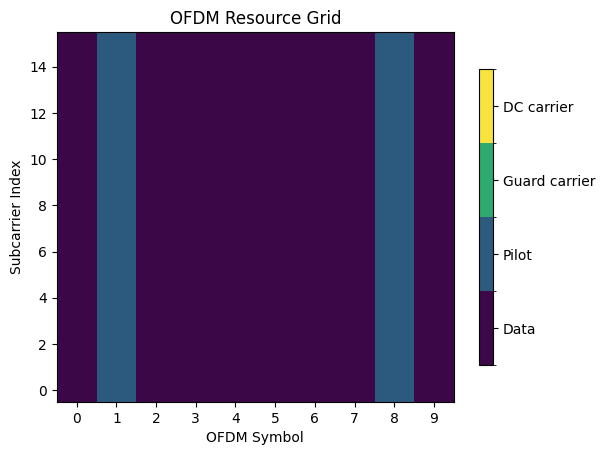

In [57]:
resource_grid = sn.ofdm.ResourceGrid(
    num_ofdm_symbols=10,
    fft_size=16,
    subcarrier_spacing=30e3,
    num_tx=NUM_UT,
    num_streams_per_tx=NUM_STREAMS_PER_TX,
    cyclic_prefix_length=6,
    pilot_pattern="kronecker",
    pilot_ofdm_symbol_indices=[1,8]
)

resource_grid_mapper = sn.ofdm.ResourceGridMapper(resource_grid=resource_grid)
frequencies = sn.channel.subcarrier_frequencies(
    num_subcarriers=resource_grid.fft_size,
    subcarrier_spacing=resource_grid.subcarrier_spacing
)

resource_grid.show();

In [58]:
constellation = sn.mapping.Constellation('qam', NUM_BITS_PER_SYMBOL)
binary_source = sn.utils.BinarySource()

mapper = sn.mapping.Mapper(constellation=constellation)
demapper = sn.mapping.Demapper('app', constellation=constellation)

ldpc_encoder = sn.fec.ldpc.LDPC5GEncoder(NUM_INFO_BITS, NUM_CODED_BITS)
ldpc_decoder = sn.fec.ldpc.LDPC5GDecoder(encoder=ldpc_encoder, hard_out=True)

ls_est = sn.ofdm.LSChannelEstimator(resource_grid=resource_grid, interpolation_type='nn')

lmmse_equ = sn.ofdm.LMMSEEqualizer(resource_grid=resource_grid, stream_management=stream_management)

channel_freq = sn.channel.ApplyOFDMChannel(add_awgn=True)

In [59]:
ut_array = sn.channel.tr38901.Antenna(
    polarization='single',
    polarization_type='V',
    antenna_pattern='omni',
    carrier_frequency=CARRIER_FREQUENCY
)

bs_array = sn.channel.tr38901.AntennaArray(
    num_rows=1,
    num_cols=NUM_BS_ANT,
    polarization='dual',
    polarization_type='cross',
    antenna_pattern='38.901',
    carrier_frequency=CARRIER_FREQUENCY
)

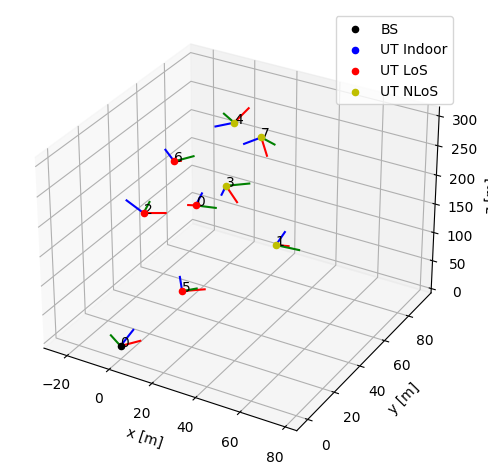

In [60]:
channel_model=sn.channel.tr38901.UMi(
  carrier_frequency=CARRIER_FREQUENCY,
  o2i_model='low',
  ut_array=ut_array,
  bs_array=bs_array,
  direction='uplink',
  enable_pathloss=False,
  enable_shadow_fading=False
)

topology = sn.channel.gen_single_sector_topology(
    batch_size=BATCH_SIZE,
    indoor_probability=0,
    num_ut=NUM_UT,
    scenario='umi',
    bs_height=BS_HEIGHT,
    max_ut_height=MAX_UT_HEIGHT,
    min_ut_height=MIN_UT_HEIGHT
)

channel_model.set_topology(*topology)

channel_model.show_topology();

In [61]:
bits = binary_source([
    BATCH_SIZE,
    NUM_UT,
    resource_grid.num_streams_per_tx,
    NUM_INFO_BITS
])
coded_bits = ldpc_encoder(bits)
qam_symbols = mapper(coded_bits)
ofdm_symbols = resource_grid_mapper(qam_symbols)

a, tau = channel_model(
    num_time_samples=resource_grid.num_ofdm_symbols,
    sampling_frequency=1/resource_grid.ofdm_symbol_duration
)
h_freq = sn.channel.cir_to_ofdm_channel(
    frequencies=frequencies,
    a=a,
    tau=tau,
    normalize=True
)

bers = []

for SNR in snrs:

    no = sn.utils.ebnodb2no(
        coderate=CODERATE,
        num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
        resource_grid=resource_grid,
        ebno_db=SNR
    )   

    received_symbols = channel_freq([ofdm_symbols, h_freq, no])
    estimation, err_var = ls_est([received_symbols, no])
    equalized_symbols, no_eff = lmmse_equ([ received_symbols, estimation, err_var, no])
    llr = demapper([equalized_symbols, no_eff])
    decoded_bits = ldpc_decoder(llr)

    ber = sn.utils.compute_ber(bits, decoded_bits)

    bers.append(ber)

    print(f'SNR = {SNR} | BER = {ber}')

SNR = -5.0 | BER = 0.35107421875
SNR = -4.0 | BER = 0.35986328125
SNR = -3.0 | BER = 0.33642578125
SNR = -2.0 | BER = 0.3212890625
SNR = -1.0 | BER = 0.32080078125
SNR = 0.0 | BER = 0.34326171875
SNR = 1.0 | BER = 0.32958984375
SNR = 2.0 | BER = 0.3310546875
SNR = 3.0 | BER = 0.34375
SNR = 4.0 | BER = 0.3369140625
SNR = 5.0 | BER = 0.3349609375
SNR = 6.0 | BER = 0.32373046875
SNR = 7.0 | BER = 0.32080078125
SNR = 8.0 | BER = 0.3349609375
SNR = 9.0 | BER = 0.3466796875
SNR = 10.0 | BER = 0.35595703125
SNR = 11.0 | BER = 0.34765625
SNR = 12.0 | BER = 0.3388671875
SNR = 13.0 | BER = 0.33642578125
SNR = 14.0 | BER = 0.337890625
SNR = 15.0 | BER = 0.35302734375
SNR = 16.0 | BER = 0.3525390625
SNR = 17.0 | BER = 0.35009765625
SNR = 18.0 | BER = 0.35302734375
SNR = 19.0 | BER = 0.3505859375
SNR = 20.0 | BER = 0.35009765625


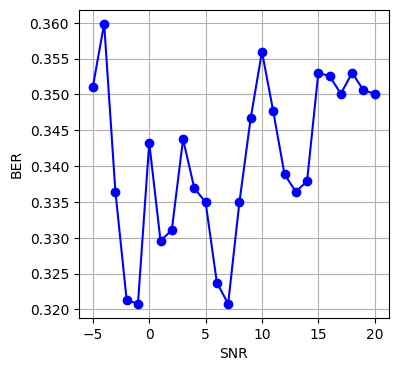

In [62]:
plt.figure(figsize=(4,4))
plt.plot(snrs, bers, color='b', marker='o')
plt.xlabel('SNR')
plt.ylabel('BER')
plt.grid()